## Image Search Using Azure Cognitive Search

### 0. Environment preparation

Requirements for this notebook to run:

- ```pip install azure-search-documents==11.4.0b11 --pre```

- ```pip install azure-ai-vision==0.13.0b1```


In [7]:
# Standard imports
import requests
import json
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

from PIL import Image
from tenacity import retry, stop_after_attempt, wait_random_exponential
from dotenv import load_dotenv

# Azure Credentials
from azure.core.credentials import AzureKeyCredential

# Azure AI Vision SDK
import azure.ai.vision as sdk

# Azure Cognitive Search imports
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorFilterMode, RawVectorQuery
from azure.search.documents.indexes.models import (  
    SearchFieldDataType,
    SimpleField,
    SearchableField,
    SearchField,
    VectorSearch,
    HnswVectorSearchAlgorithmConfiguration,
    VectorSearchAlgorithmKind,
    HnswParameters,
    ExhaustiveKnnVectorSearchAlgorithmConfiguration,
    ExhaustiveKnnParameters,
    VectorSearchProfile,
    SearchIndex
)  

In [61]:
# Central variables image search:
if not load_dotenv('./mydotenv.env'): raise Exception(".env file not found")

# Azure Computer Vision
key = os.getenv("AZURE_CV_KEY")
endpoint = os.getenv("AZURE_CV_ENDPOINT")

# Azure Cognitive Search
cs_key = os.getenv("COG_SEARCH_ADMIN_KEY")
cs_endpoint = os.getenv("COG_SEARCH_ENDPOINT")

image_root = './source/'

### 1. Helper Functions

In [58]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6)) # automatic retry in case of a failing API call
def get_embedding(imagefile):
    """
    Get embedding from an image using Azure Computer Vision 4
    """
    # settings
    model = "?api-version=2023-02-01-preview&modelVersion=latest"
    url = endpoint + "/computervision/retrieval:vectorizeImage" + model
    headers = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": key,
    }

    # Read the image file
    with open(imagefile, "rb") as f:
        data = f.read()

    # Sending the requests
    r = requests.post(url, data=data, headers=headers)
    results = r.json()
    embeddings = results['vector']

    return embeddings

def get_text_embedding(text):
    """
    Get embedding from text using Azure Computer Vision 4
    """

    # settings
    #options = "&features=caption,tags"
    model = "?api-version=2023-02-01-preview&modelVersion=latest"
    url = endpoint + "/computervision/retrieval:vectorizeText" + model
    headers = {
        "Content-type": "application/json",
        "Ocp-Apim-Subscription-Key": key,
    }

    data = {
        "text": text
    }

    # Sending the requests
    r = requests.post(url, data=json.dumps(data), headers=headers)
    results = r.json()
    embeddings = results['vector']

    return embeddings

def analyze_image(imagefile):

    service_options = sdk.VisionServiceOptions(endpoint, key)
    vision_source = sdk.VisionSource(filename=imagefile)
    analysis_options = sdk.ImageAnalysisOptions()
    analysis_options.features = (
        sdk.ImageAnalysisFeature.CAPTION |
        sdk.ImageAnalysisFeature.TAGS
    )

    image_analyzer = sdk.ImageAnalyzer(service_options, vision_source, analysis_options)
    result = image_analyzer.analyze()
    caption = result.caption.content
    tags_str = ", ".join(tag.name for tag in result.tags)

    return caption, tags_str

def show_images(images, cols=2, source='url', savedir='', show_title=False, titles=None):
    """
    Get images from URL and display them in a grid. Optionally save or retrieve images to/from local dir. 
    
    Parameters
    ----------
    images : list
        List of image urls or local file paths.
    cols : int
        Number of columns in the grid.
    source : str
        'url' or 'local'
    savedir : str
        Directory to save images to.
    show_title : bool
        Display filename as image title (local files only)
    """
    
    if savedir != '':
        os.makedirs(savedir, exist_ok=True)
        
    rows = int(math.ceil(len(images) / cols))

    fig = plt.figure(figsize=(cols * 5, rows * 5)) # specifying the overall grid size. TODO: 7,5 for landscape images

    for i, image_url in enumerate(images):
        plt.subplot(rows, cols,i+1)  
        
        if source == 'url':
            response = requests.get(image_url)
            img = Image.open(BytesIO(response.content))
            
            # save images if savedir is specified
            if savedir != '':
                
                # get list of png files
                png_filenames = [image for image in os.listdir(savedir) if image.endswith('.png')]
                # get highest index from existing files
                if png_filenames == []:
                    max_index = 0
                else:
                    max_index = max([int(filename.strip('.png')) for filename in png_filenames])

                # save new file with index + 1
                new_filename = f'{max_index+1:03d}.png'
                fp = os.path.join(savedir, new_filename)
                img.save(fp, 'PNG')            
            
        else: 
            img = Image.open(image_url) # local file
            if show_title:
                if titles is None: plt.title(image_url)
                else: plt.title(titles[i])


        plt.imshow(img)
        plt.axis('off')

    fig.tight_layout()

    plt.show()

### 2. Data Preparation

#### Load data from images or from pickle

In [47]:
# optionally reload existing dataframe
df = pd.read_pickle('men-women-animals-embeddings.pkl')

In [124]:
# Generate the data frame, reading the image, getting the embeddings and descriptions
df = pd.DataFrame(columns=['file', 'class', 'embedding', 'img_caption'])

idx = 0
for root, dirs, files in os.walk(image_root):
    for dir in dirs:
        print(f"Subfolder: {dir}")
        subdir = os.path.join(root, dir)
        for file in os.listdir(subdir):
            if file.endswith('.png') or file.endswith('.jpg'):
                # print(f"Image file: {file}")
                full_path = os.path.join(image_root, dir, file)

                embedding = get_embedding(imagefile=full_path)

                caption, tags = analyze_image(imagefile=full_path)

                row = [full_path, dir, embedding, f"{caption} - {tags}"]
                df.loc[idx] = row
                idx += 1

# optionally save new dataframe for later reuse. Pickle format selcted to preserve embeddings data type
df.to_pickle('./men-women-animals-embeddings.pkl')

Subfolder: animals
Subfolder: men
Subfolder: women


#### Explore the data

In [126]:
display(df.sample(6))

file    class  \
40   ./source/animals/Picture193.jpg  animals   
34   ./source/animals/Picture187.jpg  animals   
119     ./source/women/Picture69.jpg    women   
98       ./source/men/Picture151.jpg      men   
31   ./source/animals/Picture184.jpg  animals   
23   ./source/animals/Picture176.jpg  animals   

                                             embedding  \
40   [-1.6289062, -0.8491211, 0.63183594, 0.7666015...   
34   [-1.5742188, 0.48950195, -3.0214844, -2.076171...   
119  [-0.14086914, -0.26513672, -4.7539062, -0.5942...   
98   [2.1972656, -1.3603516, 0.34399414, 0.65527344...   
31   [-3.8085938, -3.1972656, 0.39990234, 0.2851562...   
23   [-2.1269531, -0.3244629, -1.1933594, -0.500976...   

                                           img_caption  
40   a close up of a sheep - mammal, animal, snout,...  
34   close up of a monkey's face - animal, mammal, ...  
119  a woman holding a skateboard - person, purple,...  
98   a man looking away from the camera - person, h...  
31   a group of frogs on a branch - animal, frog, a...  
23   a baby elephant and adult elephant in a grassy...

a man sitting at a table with a cup - person, human face, clothing, indoor, man, wall, furniture, table, sitting


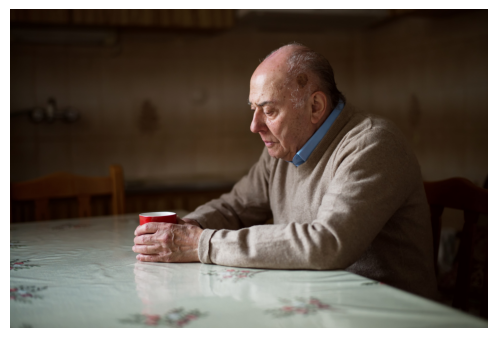

In [133]:
# Show 1 image
sample = df.sample(1)
print(sample.img_caption.values[0])
show_images(images = [sample.sample(1).file.values[0]], source='local')

In [ ]:
# Generate a dictionary with the data content
df["id"] = df.index
df["id"] = df.id.astype("string")
df.columns = ['title', 'class', 'embedding', 'caption', 'id']
docs = df.to_dict('records')

### 3. Create the Azure Cognitive Search with the data frame content

In [24]:
# Azure credentials
credential = AzureKeyCredential(cs_key)

# Index name
index_name = "img_search"

#### Create a search index

In [17]:
# Create a search index
index_client = SearchIndexClient(endpoint=cs_endpoint, credential=credential)

fields = [
    SimpleField    (name = "id"       , type = SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name = "title"    , type = SearchFieldDataType.String),
    SearchableField(name = "class"    , type = SearchFieldDataType.String, filterable=True),
    SearchableField(name = "caption"  , type = SearchFieldDataType.String, filterable=True),
    SearchField    (name = "embedding", type = SearchFieldDataType.Collection(SearchFieldDataType.Single),searchable=True, vector_search_dimensions=1024, vector_search_profile="myHnswProfile"),
]

# Configure the vector search configuration  
vector_search = VectorSearch(
    algorithms=[
        HnswVectorSearchAlgorithmConfiguration(
            name="myHnsw",
            kind=VectorSearchAlgorithmKind.HNSW,
            parameters=HnswParameters(
                m=4,
                ef_construction=400,
                ef_search=500,
                metric= "cosine"
            )
        ),
        ExhaustiveKnnVectorSearchAlgorithmConfiguration(
            name="myExhaustiveKnn",
            kind=VectorSearchAlgorithmKind.EXHAUSTIVE_KNN,
            parameters=ExhaustiveKnnParameters(
                metric= "cosine"
            )
        )
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswProfile",
            algorithm="myHnsw"
        ),
        VectorSearchProfile(
            name="myExhaustiveKnnProfile",
            algorithm="myExhaustiveKnn"
        )
    ],
)

# Create the search index with the semantic settings
index = SearchIndex(name = index_name, fields=fields, vector_search=vector_search)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')


 img_search created


#### Populate the index

In [51]:
# Populate the index
search_client = SearchClient(endpoint = cs_endpoint, index_name=index_name, credential=credential)
result = search_client.upload_documents(docs)
print(f"Uploaded {len(docs)} documents") 

Uploaded 150 documents


### 4. Search Results

#### Same results with "in-memory" vector search

Title: ./source/women/Picture95.jpg
Score: 0.63321966
Content: a woman in a colorful dress holding a paint roller - person, wall, human face, clothing, smile, woman, scarf, indoor
Category: women

Title: ./source/women/Picture96.jpg
Score: 0.5854962
Content: a woman painting on a canvas - wall, clothing, person, tripod, indoor, art, easel, furniture, woman, painting
Category: women

Title: ./source/women/Picture63.jpg
Score: 0.57784104
Content: a woman with a yellow head wrap - human face, clothing, person, hairstyle, fashion accessory, wall, yellow, wearing, woman
Category: women

Title: ./source/women/Picture60.jpg
Score: 0.5778409
Content: a woman in a red outfit - human face, person, clothing, shoulder, wall, dance, sunglasses, smile, waist, elbow, woman, girl, fashion, wearing
Category: women

Title: ./source/women/Picture90.jpg
Score: 0.57717395
Content: a woman painting on a canvas - clothing, tripod, person, art, easel, human face, indoor, wall, standing, woman
Category: women


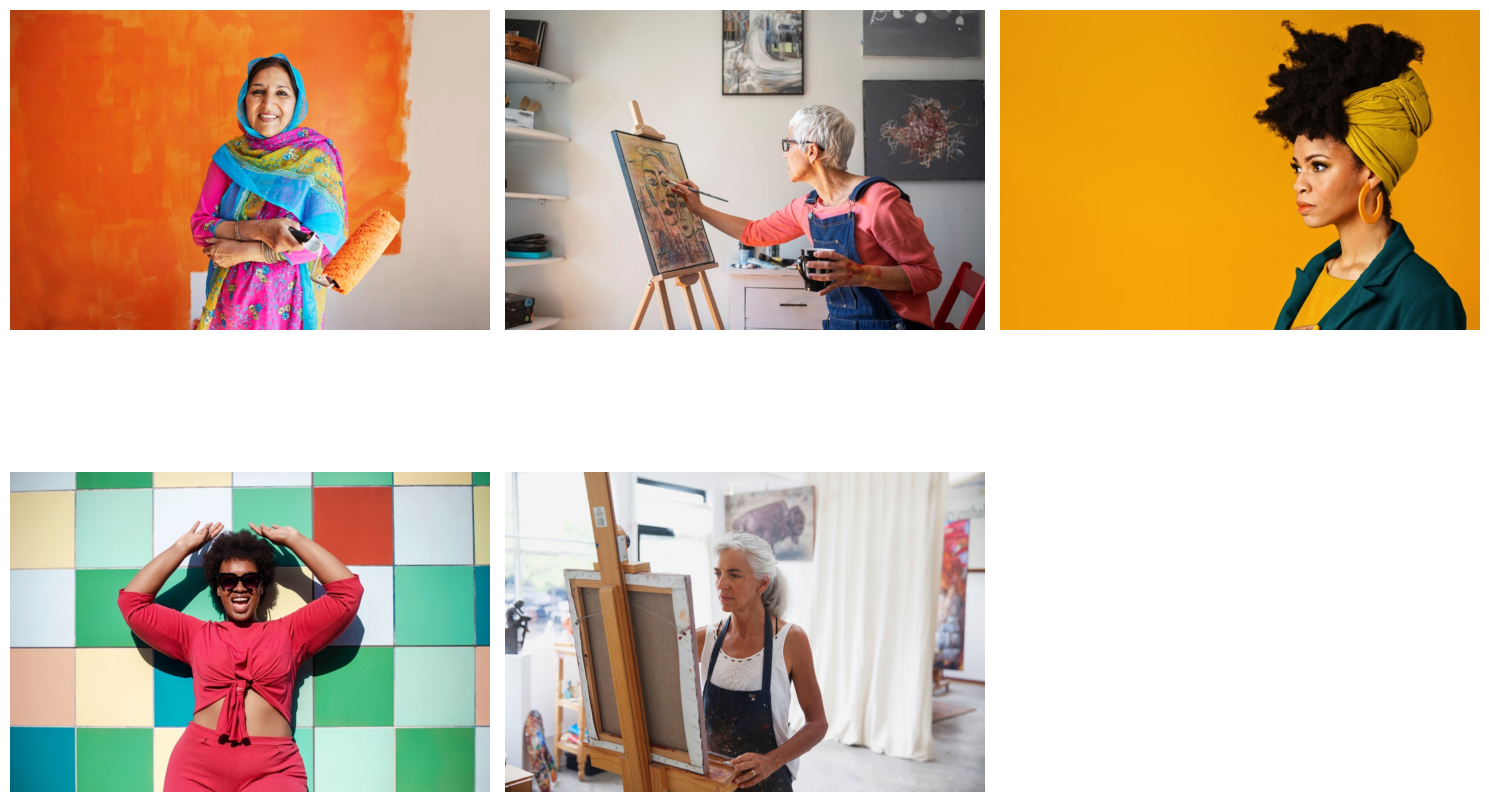

In [95]:
query = 'woman in colorful dress painting wall orange'
  
search_client = SearchClient(cs_endpoint, index_name, credential=credential)  

vector_query = RawVectorQuery(vector=get_text_embedding(query), k=5, fields="embedding")

results = search_client.search(  
    search_text = None,  
    vector_filter_mode=VectorFilterMode.PRE_FILTER,
    vector_queries = [vector_query],
    select=["title", "class", "caption"],
    top=5
)  
img_paths = []  
for result in results:  
    print(f"Title: {result['title']}")  
    print(f"Score: {result['@search.score']}")  
    print(f"Content: {result['caption']}")  
    print(f"Category: {result['class']}\n") 
    img_paths.append(result['title'])


show_images(images=img_paths, cols=3, source='local')

#### Search for "group of animals" with vector search

Title: ./source/animals/Picture184.jpg
Score: 0.58389086
Content: a group of frogs on a branch - animal, frog, amphibian, outdoor
Category: animals

Title: ./source/animals/Picture201.jpg
Score: 0.58281106
Content: a group of lions running in a field - animal, mammal, lion, outdoor, big cat, terrestrial animal, grass, wildlife, big cats, safari, masai lion, snout, fur, ground, field, brown
Category: animals

Title: ./source/animals/Picture191.jpg
Score: 0.58202165
Content: a group of cows looking at the camera - animal, cow, mammal, cattle, livestock, bovine, outdoor, dairy cow, herd, ox, standing, brown
Category: animals

Title: ./source/animals/Picture168.jpg
Score: 0.57637554
Content: a group of monkeys on a log - animal, mammal, primate, outdoor, terrestrial animal, wildlife, old world monkey, new world monkey, macaque, langur, monkey
Category: animals

Title: ./source/animals/Picture169.jpg
Score: 0.57449245
Content: two giraffes standing in a grassy field - animal, mammal, grass,

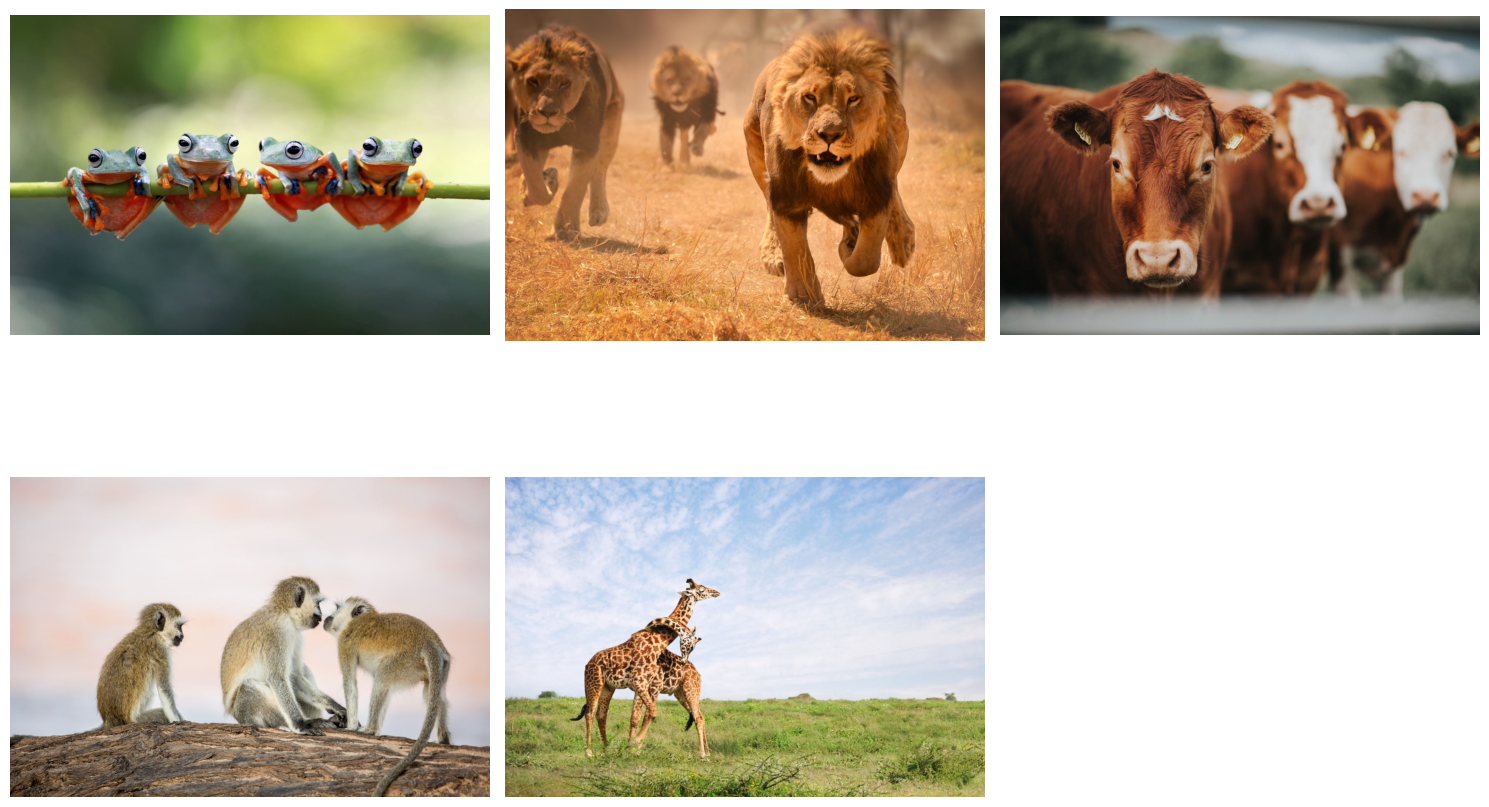

In [101]:
query = 'group of animals'
  
search_client = SearchClient(cs_endpoint, index_name, credential=credential)  

vector_query = RawVectorQuery(vector=get_text_embedding(query), k=5, fields="embedding")

results = search_client.search(  
    search_text = None,  
    vector_filter_mode=VectorFilterMode.PRE_FILTER,
    vector_queries = [vector_query],
    select=["title", "class", "caption"],
    top=5
)  
img_paths = []  
for result in results:  
    print(f"Title: {result['title']}")  
    print(f"Score: {result['@search.score']}")  
    print(f"Content: {result['caption']}")  
    print(f"Category: {result['class']}\n") 
    img_paths.append(result['title'])


show_images(images=img_paths, cols=3, source='local')

#### Search for "one single animal" with vector search

Title: ./source/animals/Picture193.jpg
Score: 0.59088045
Content: a close up of a sheep - mammal, animal, snout, livestock, sheep, standing, ground, cow
Category: animals

Title: ./source/animals/Picture171.jpg
Score: 0.5907092
Content: a close up of a monkey - mammal, animal, primate, ape, black and white, great ape, gorilla, common chimpanzee, chimpanzee, terrestrial animal, simian, outdoor, monkey, wildlife, orangutan, monochrome
Category: animals

Title: ./source/animals/Picture199.jpg
Score: 0.5899969
Content: a close up of a lizard's face - animal, reptile, green, chameleon
Category: animals

Title: ./source/animals/Picture197.jpg
Score: 0.5897978
Content: a close-up of a sheep - mammal, animal, sheep, livestock, snout, terrestrial animal, outdoor, standing
Category: animals

Title: ./source/animals/Picture166.jpg
Score: 0.58904815
Content: a zebra with black background - animal, mammal, zebra, black and white, wildlife, terrestrial animal, snout, standing
Category: animals



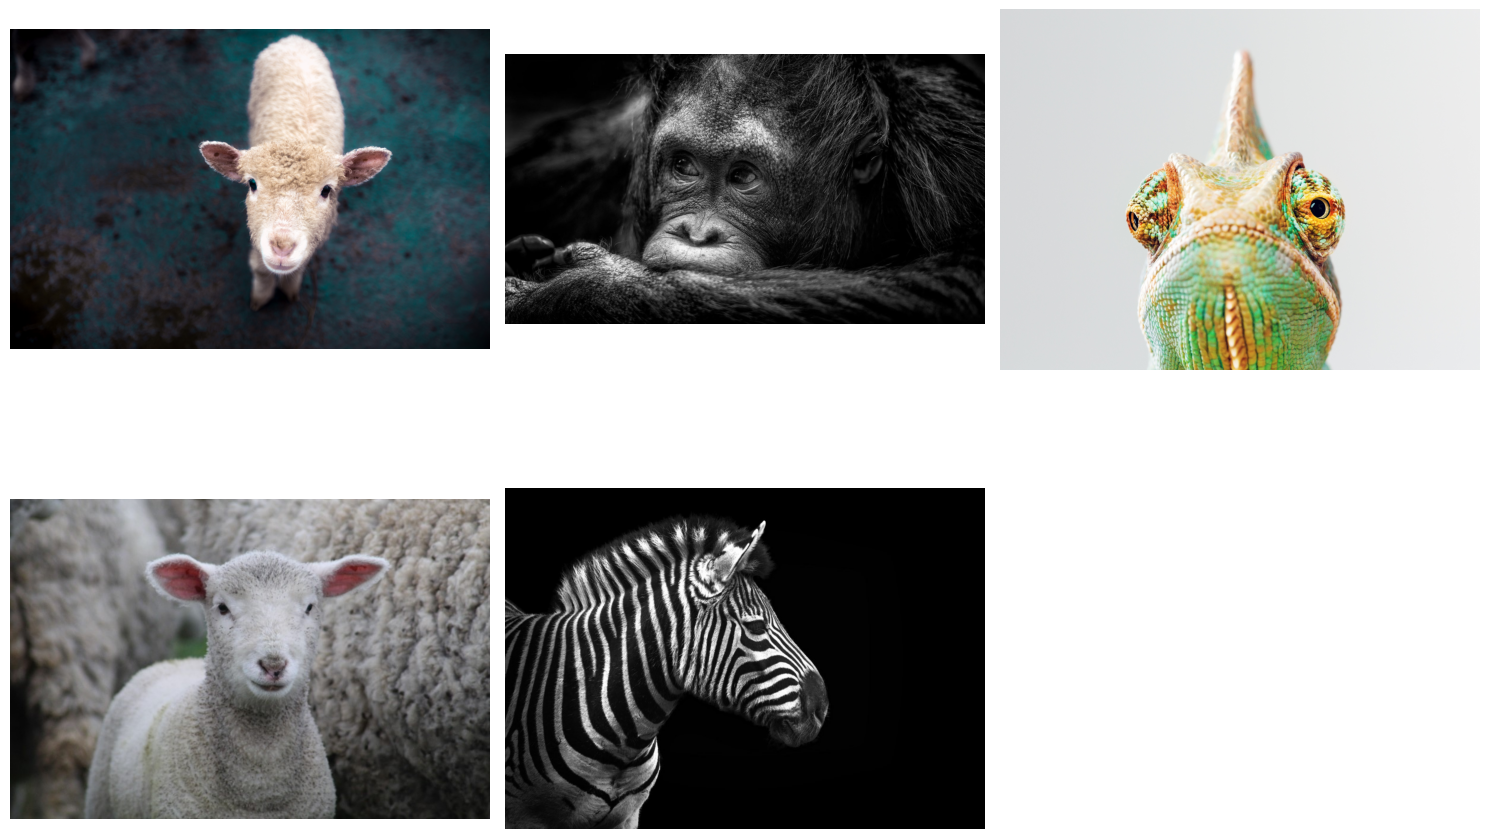

In [102]:
query = 'one single animal'
  
search_client = SearchClient(cs_endpoint, index_name, credential=credential)  

vector_query = RawVectorQuery(vector=get_text_embedding(query), k=5, fields="embedding")

results = search_client.search(  
    search_text = None,  
    vector_filter_mode=VectorFilterMode.PRE_FILTER,
    vector_queries = [vector_query],
    select=["title", "class", "caption"],
    top=5
)  
img_paths = []  
for result in results:  
    print(f"Title: {result['title']}")  
    print(f"Score: {result['@search.score']}")  
    print(f"Content: {result['caption']}")  
    print(f"Category: {result['class']}\n") 
    img_paths.append(result['title'])


show_images(images=img_paths, cols=3, source='local')

#### Text only Search

With Text only search, the images that are not described containing the text are not returned.

Title: ./source/men/Picture105.jpg
Score: 2.4672887
Content: a man smiling at camera - human face, person, bookcase, smile, clothing, indoor, book, man, shelving, wall, shelf, glasses
Category: men

Title: ./source/men/Picture129.jpg
Score: 2.1724496
Content: a man sitting on the floor with a laptop - person, clothing, indoor, bookcase, book, human face, furniture, glasses, wall, man, laptop, jeans, shelf, sitting
Category: men

Title: ./source/men/Picture127.jpg
Score: 1.4181246
Content: a man holding a tablet - human face, bookcase, person, indoor, man, clothing, book, shelving, publication, shelf, wall, glasses, library
Category: men

Title: ./source/men/Picture141.jpg
Score: 1.2408907
Content: a man with glasses standing in front of a bookshelf - bookcase, clothing, person, book, human face, man, shelving, indoor, publication, public library, shelf, library, room, glasses
Category: men



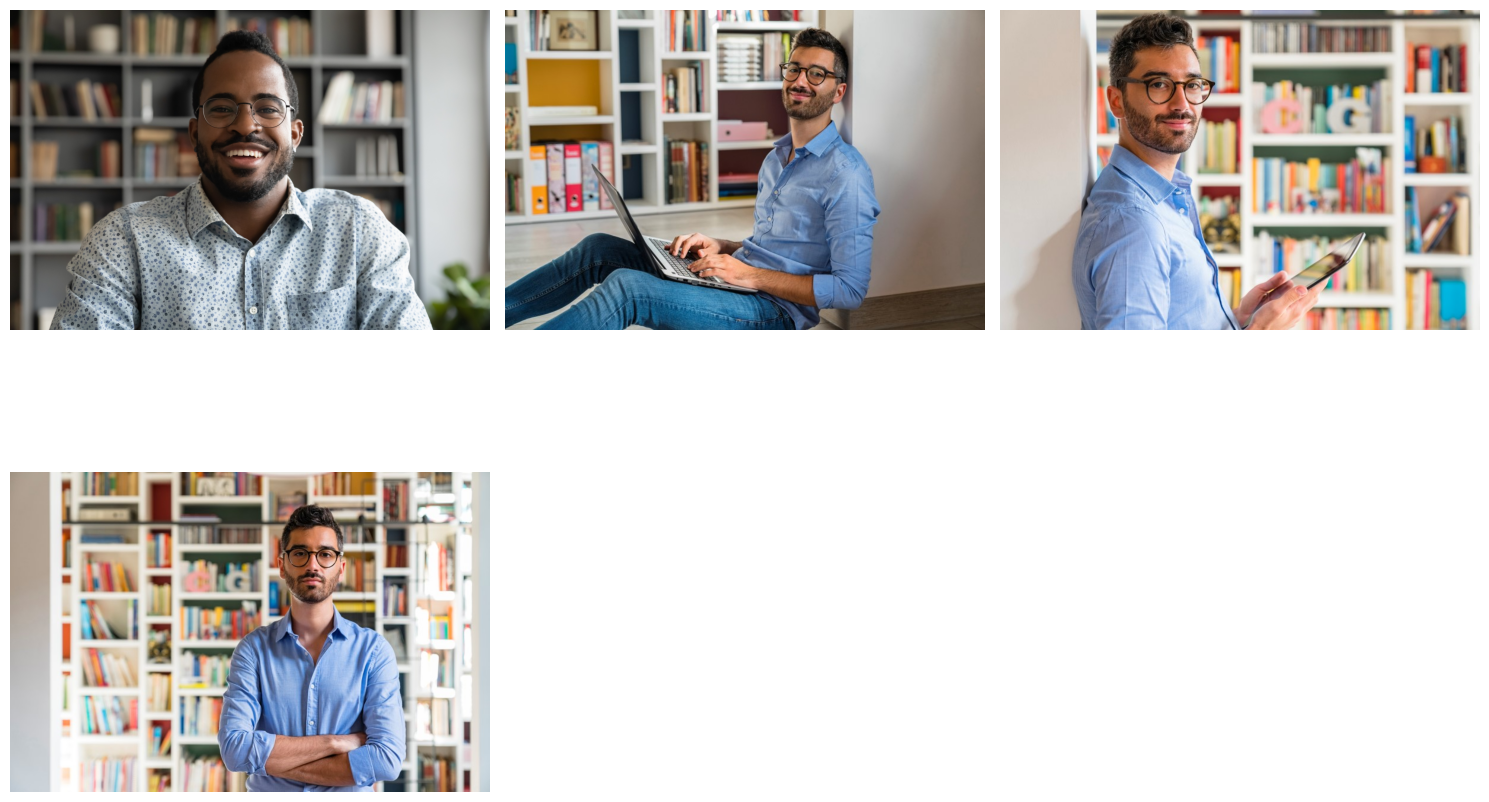

In [114]:
query = 'books bookcase'
  
search_client = SearchClient(cs_endpoint, index_name, credential=credential)  

results = search_client.search(  
    search_text = query,  
    vector_filter_mode=VectorFilterMode.PRE_FILTER,
    vector_queries = None,
    select=["title", "class", "caption"],
    top=5
)  
img_paths = []  
for result in results:  
    print(f"Title: {result['title']}")  
    print(f"Score: {result['@search.score']}")  
    print(f"Content: {result['caption']}")  
    print(f"Category: {result['class']}\n") 
    img_paths.append(result['title'])


show_images(images=img_paths, cols=3, source='local')

#### Image Similarity (Vector Only Search)

The results are searching for what the Florence model understands as a bookshelf. One result is not correct.

Title: ./source/men/Picture141.jpg
Score: 0.5857408
Content: a man with glasses standing in front of a bookshelf - bookcase, clothing, person, book, human face, man, shelving, indoor, publication, public library, shelf, library, room, glasses
Category: men

Title: ./source/men/Picture127.jpg
Score: 0.5785767
Content: a man holding a tablet - human face, bookcase, person, indoor, man, clothing, book, shelving, publication, shelf, wall, glasses, library
Category: men

Title: ./source/men/Picture129.jpg
Score: 0.56750363
Content: a man sitting on the floor with a laptop - person, clothing, indoor, bookcase, book, human face, furniture, glasses, wall, man, laptop, jeans, shelf, sitting
Category: men

Title: ./source/women/Picture61.jpg
Score: 0.5638716
Content: a woman with blonde hair holding her finger to her mouth - human face, person, clothing, woman, skin, eyebrow, portrait, indoor, blond, layered hair, wall, girl, lady
Category: women

Title: ./source/men/Picture150.jpg
Score: 0.5630

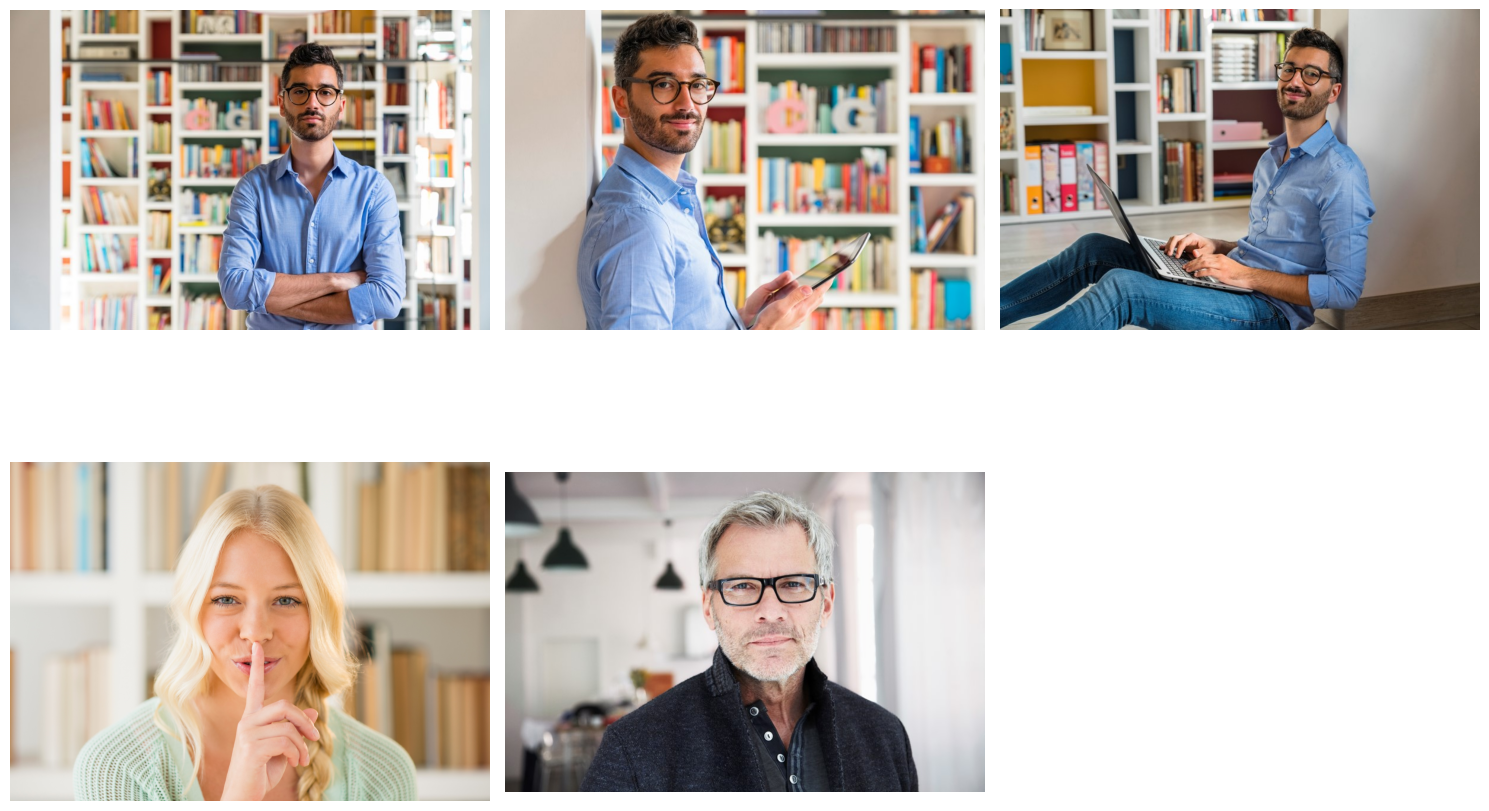

In [112]:
query = 'books bookcase'
  
search_client = SearchClient(cs_endpoint, index_name, credential=credential)  

vector_query = RawVectorQuery(vector=get_text_embedding(query), k=5, fields="embedding")

results = search_client.search(  
    search_text = None,  
    vector_filter_mode=VectorFilterMode.PRE_FILTER,
    vector_queries = [vector_query],
    select=["title", "class", "caption"],
    top=5
)  
img_paths = []  
for result in results:  
    print(f"Title: {result['title']}")  
    print(f"Score: {result['@search.score']}")  
    print(f"Content: {result['caption']}")  
    print(f"Category: {result['class']}\n") 
    img_paths.append(result['title'])


show_images(images=img_paths, cols=3, source='local')

#### Hybrid Search

Combining the image similarity with the description, we get the top results with images displaying bookcases, even when they are not mentioned in the text descriptions.

Title: ./source/men/Picture141.jpg
Score: 0.03253968432545662
Content: a man with glasses standing in front of a bookshelf - bookcase, clothing, person, book, human face, man, shelving, indoor, publication, public library, shelf, library, room, glasses
Category: men

Title: ./source/men/Picture127.jpg
Score: 0.032522473484277725
Content: a man holding a tablet - human face, bookcase, person, indoor, man, clothing, book, shelving, publication, shelf, wall, glasses, library
Category: men

Title: ./source/men/Picture129.jpg
Score: 0.032522473484277725
Content: a man sitting on the floor with a laptop - person, clothing, indoor, bookcase, book, human face, furniture, glasses, wall, man, laptop, jeans, shelf, sitting
Category: men

Title: ./source/men/Picture105.jpg
Score: 0.01666666753590107
Content: a man smiling at camera - human face, person, bookcase, smile, clothing, indoor, book, man, shelving, wall, shelf, glasses
Category: men

Title: ./source/women/Picture61.jpg
Score: 0.015873016

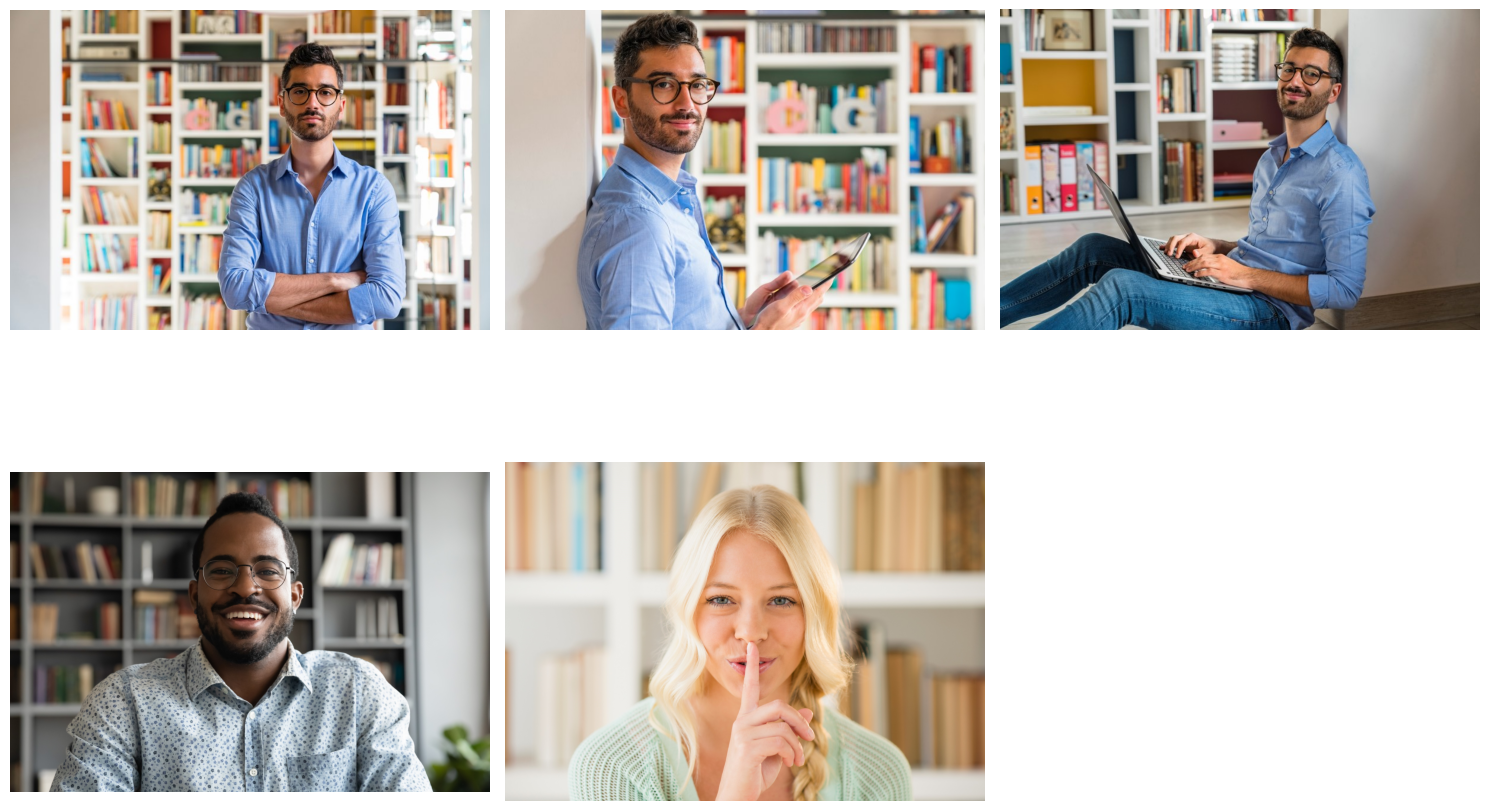

In [113]:
query = 'books bookcase'
  
search_client = SearchClient(cs_endpoint, index_name, credential=credential)  

vector_query = RawVectorQuery(vector=get_text_embedding(query), k=5, fields="embedding")

results = search_client.search(  
    search_text = query,  
    vector_filter_mode=VectorFilterMode.PRE_FILTER,
    vector_queries = [vector_query],
    select=["title", "class", "caption"],
    top=5
)  
img_paths = []  
for result in results:  
    print(f"Title: {result['title']}")  
    print(f"Score: {result['@search.score']}")  
    print(f"Content: {result['caption']}")  
    print(f"Category: {result['class']}\n") 
    img_paths.append(result['title'])


show_images(images=img_paths, cols=3, source='local')